In [1]:
import os
from typing import Union
from datasets import load_dataset
import pandas as pd

In [2]:
PROJECT_ROOT = ""

dataset_config = {
  "LOADING_SCRIPT_FILES": os.path.join(PROJECT_ROOT, "/content/drive/MyDrive/crema.py"),
  "CONFIG_NAME": "clean",
  "DATA_DIR": os.path.join(PROJECT_ROOT, "/content/drive/MyDrive/archive.zip"),
  "CACHE_DIR": os.path.join(PROJECT_ROOT, "cache_crema"),
}
ds = load_dataset(
  dataset_config["LOADING_SCRIPT_FILES"],
  dataset_config["CONFIG_NAME"],
  data_dir=dataset_config["DATA_DIR"],
  cache_dir=dataset_config["CACHE_DIR"]
)
print(ds)

DatasetDict({
    train: Dataset({
        features: ['file', 'label'],
        num_rows: 7442
    })
})


In [3]:
from datasets import DatasetDict

train_test = ds["train"].train_test_split(shuffle=True, test_size=0.2)
# Split the 20% test + valid in half test, half valid
test_valid = train_test["test"].train_test_split(test_size=0.5)
# gather everyone if you want to have a single DatasetDict
fin_ds = DatasetDict({
    'train': train_test['train'],
    'test': test_valid['test'],
    'val': test_valid['train']})

In [4]:
from datasets import Audio
audio_dataset = fin_ds.cast_column("file", Audio())


In [5]:
audio_dataset = audio_dataset.class_encode_column("label")

Flattening the indices:   0%|          | 0/5953 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/5953 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/745 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/745 [00:00<?, ? examples/s]

Flattening the indices:   0%|          | 0/744 [00:00<?, ? examples/s]

Casting to class labels:   0%|          | 0/744 [00:00<?, ? examples/s]

In [6]:
audio_dataset["train"].features["label"]

ClassLabel(names=['ANG', 'DIS', 'FEA', 'HAP', 'NEU', 'SAD'], id=None)

In [7]:
labels = audio_dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [8]:
print(id2label)

{'0': 'ANG', '1': 'DIS', '2': 'FEA', '3': 'HAP', '4': 'NEU', '5': 'SAD'}


In [9]:
from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-base")

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(


In [10]:
# Maximum duration of the input audio file we feed to our Wav2Vec 2.0 model.
MAX_DURATION = 2
# Sampling rate is the number of samples of audio recorded every second
SAMPLING_RATE = 16000
BATCH_SIZE = 32  # Batch-size for training and evaluating our model.
NUM_CLASSES = 6
HIDDEN_DIM = 768  # Dimension of our model output (768 in case of Wav2Vec 2.0 - Base).
MAX_SEQ_LENGTH = MAX_DURATION * SAMPLING_RATE  # Maximum length of the input audio file.
# Wav2Vec 2.0 results in an output frequency with a stride of about 20ms.
MAX_FRAMES = 99
MAX_EPOCHS = 10 # Maximum number of training epochs.

MODEL_CHECKPOINT = "facebook/wav2vec2-base"  # Name of pretrained model from Hugging Face Model Hub

In [11]:
feature_extractor = AutoFeatureExtractor.from_pretrained(
    MODEL_CHECKPOINT, return_attention_mask=True)

In [12]:
def preprocess_function(examples):
    audio_arrays = [x["array"] for x in examples["file"]]
    inputs = feature_extractor(
        audio_arrays,
        sampling_rate=feature_extractor.sampling_rate,
        max_length=MAX_SEQ_LENGTH,
        truncation=True,
        padding=True,
    )
    return inputs

In [13]:
processed_audio_dataset = audio_dataset.map(
    preprocess_function, remove_columns=["file"], batched=True
)


Map:   0%|          | 0/5953 [00:00<?, ? examples/s]

Map:   0%|          | 0/745 [00:00<?, ? examples/s]

Map:   0%|          | 0/744 [00:00<?, ? examples/s]

In [14]:
processed_audio_dataset["train"] = processed_audio_dataset["train"].select(
    [i for i in range((len(processed_audio_dataset["train"]) // BATCH_SIZE) * BATCH_SIZE)]
)
processed_audio_dataset["val"] = processed_audio_dataset["val"].select(
    [i for i in range((len(processed_audio_dataset["val"]) // BATCH_SIZE) * BATCH_SIZE)]
)
processed_audio_dataset["test"] = processed_audio_dataset["test"].select(
    [i for i in range((len(processed_audio_dataset["test"]) // BATCH_SIZE) * BATCH_SIZE)]
)

In [15]:
train = processed_audio_dataset["train"].shuffle(seed=42).with_format("numpy")[:]
val = processed_audio_dataset["val"].shuffle(seed=42).with_format("numpy")[:]
test = processed_audio_dataset["test"].shuffle(seed=42).with_format("numpy")[:]

In [16]:
train_x = {x: y for x, y in train.items() if x != "label"}
val_x = {x: y for x, y in val.items() if x != "label"}
test_x = {x: y for x, y in test.items() if x != "label"}

In [17]:
from transformers import TFWav2Vec2Model
from tensorflow.keras import layers



def mean_pool(hidden_states, feature_lengths):
    attenion_mask = tf.sequence_mask(
        feature_lengths, maxlen=MAX_FRAMES, dtype=tf.dtypes.int64
    )
    padding_mask = tf.cast(
        tf.reverse(tf.cumsum(tf.reverse(attenion_mask, [-1]), -1), [-1]),
        dtype=tf.dtypes.bool,
    )
    hidden_states = tf.where(
        tf.broadcast_to(
            tf.expand_dims(~padding_mask, -1), (BATCH_SIZE, MAX_FRAMES, HIDDEN_DIM)
        ),
        0.0,
        hidden_states,
    )
    pooled_state = tf.math.reduce_sum(hidden_states, axis=1) / tf.reshape(
        tf.math.reduce_sum(tf.cast(padding_mask, dtype=tf.dtypes.float32), axis=1),
        [-1, 1],
    )
    return pooled_state


class TFWav2Vec2ForAudioClassification(layers.Layer):
    """Combines the encoder and decoder into an end-to-end model for training."""

    def __init__(self, model_checkpoint, num_classes):
        super().__init__()
        # Instantiate the Wav2Vec 2.0 model without the Classification-Head
        self.wav2vec2 = TFWav2Vec2Model.from_pretrained(
            model_checkpoint, apply_spec_augment=False, from_pt=True
        )
        self.pooling = layers.GlobalAveragePooling1D()
        # Drop-out layer before the final Classification-Head
        self.intermediate_layer_dropout = layers.Dropout(0.5)
        # Classification-Head
        self.final_layer = layers.Dense(num_classes, activation="softmax")

    def call(self, inputs):
        # We take only the first output in the returned dictionary corresponding to the
        # output of the last layer of Wav2vec 2.0
        hidden_states = self.wav2vec2(inputs["input_values"])[0]

        # If attention mask does exist then mean-pool only un-masked output frames
        if tf.is_tensor(inputs["attention_mask"]):
            # Get the length of each audio input by summing up the attention_mask
            # (attention_mask = (BATCH_SIZE x MAX_SEQ_LENGTH) ∈ {1,0})
            audio_lengths = tf.cumsum(inputs["attention_mask"], -1)[:, -1]
            # Get the number of Wav2Vec 2.0 output frames for each corresponding audio input
            # length
            feature_lengths = self.wav2vec2.wav2vec2._get_feat_extract_output_lengths(
                audio_lengths
            )
            pooled_state = mean_pool(hidden_states, feature_lengths)
        # If attention mask does not exist then mean-pool only all output frames
        else:
            pooled_state = self.pooling(hidden_states)

        intermediate_state = self.intermediate_layer_dropout(pooled_state)
        final_state = self.final_layer(intermediate_state)

        return final_state

In [18]:
from transformers import TFWav2Vec2Model
import tensorflow as tf
from tensorflow import keras

def build_model():
    # Model's input
    inputs = {
        "input_values": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="float32"),
        "attention_mask": tf.keras.Input(shape=(MAX_SEQ_LENGTH,), dtype="int32"),
    }
    # Instantiate the Wav2Vec 2.0 model with Classification-Head using the desired
    # pre-trained checkpoint
    wav2vec2_model = TFWav2Vec2ForAudioClassification(MODEL_CHECKPOINT, NUM_CLASSES)(
        inputs
    )
    # Model
    model = tf.keras.Model(inputs, wav2vec2_model)
    # Loss
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    # Optimizer
    optimizer = keras.optimizers.Adam(learning_rate=1e-5)
    # Compile and return
    model.compile(loss=loss, optimizer=optimizer, metrics=["accuracy"])
    return model


model = build_model()

/usr/local/lib/python3.10/dist-packages/transformers/configuration_utils.py:380: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  warnings.warn(

TFWav2Vec2Model has backpropagation operations that are NOT supported on CPU. If you wish to train/fine-tune this model, you need a GPU or a TPU
Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFWav2Vec2Model: ['project_q.bias', 'project_hid.weight', 'quantizer.codevectors', 'project_q.weight', 'quantizer.weight_proj.weight', 'project_hid.bias', 'quantizer.weight_proj.bias']
- This IS expected if you are initializing TFWav2Vec2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a Bert

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32000)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 32000)]      0           []                               
                                                                                                  
 tf_wav2_vec2_for_audio_classif  (32, 6)             94376326    ['input_2[0][0]',                
 ication (TFWav2Vec2ForAudioCla                                   'input_1[0][0]']                
 ssification)                                                                                     
                                                                                              

In [20]:
model.fit(
    train_x,
    train["label"],
    validation_data=(val_x, val["label"]),
    batch_size=BATCH_SIZE,
    epochs=MAX_EPOCHS,
)

Epoch 1/10


186/186 [==============================] - 117s 385ms/step - loss: 1.4527 - accuracy: 0.4096 - val_loss: 1.0954 - val_accuracy: 0.5910
Epoch 2/10
186/186 [==============================] - 69s 369ms/step - loss: 1.0136 - accuracy: 0.6163 - val_loss: 1.0112 - val_accuracy: 0.6318
Epoch 3/10
186/186 [==============================] - 69s 368ms/step - loss: 0.7751 - accuracy: 0.7135 - val_loss: 0.8028 - val_accuracy: 0.7296
Epoch 4/10
186/186 [==============================] - 68s 368ms/step - loss: 0.6368 - accuracy: 0.7653 - val_loss: 0.7804 - val_accuracy: 0.7065
Epoch 5/10
186/186 [==============================] - 69s 369ms/step - loss: 0.5247 - accuracy: 0.8101 - val_loss: 0.8736 - val_accuracy: 0.7024
Epoch 6/10
186/186 [==============================] - 69s 369ms/step - loss: 0.4111 - accuracy: 0.8537 - val_loss: 0.7990 - val_accuracy: 0.7269
Epoch 7/10
186/186 [==============================] - 69s 369ms/step - loss: 0.3339 - accuracy: 0.8792 - val_loss: 0.8804 - val_accuracy: 0.

In [21]:
model.save('my_model.keras')

In [22]:
score = model.evaluate(test_x, test["label"], verbose = 0)

print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.0719540119171143
Test accuracy: 0.7241848111152649


In [44]:
import IPython.display as ipd
import random

rand_int = random.randint(0, len(test_x))

ipd.Audio(data=np.asarray(test_x["input_values"][rand_int]), autoplay=False, rate=16000)

print("Original Label is ", id2label[str(test["label"][rand_int])])
print("Predicted Label is ", id2label[str(np.argmax((preds[rand_int])))])

Original Label is  FEA
Predicted Label is  FEA


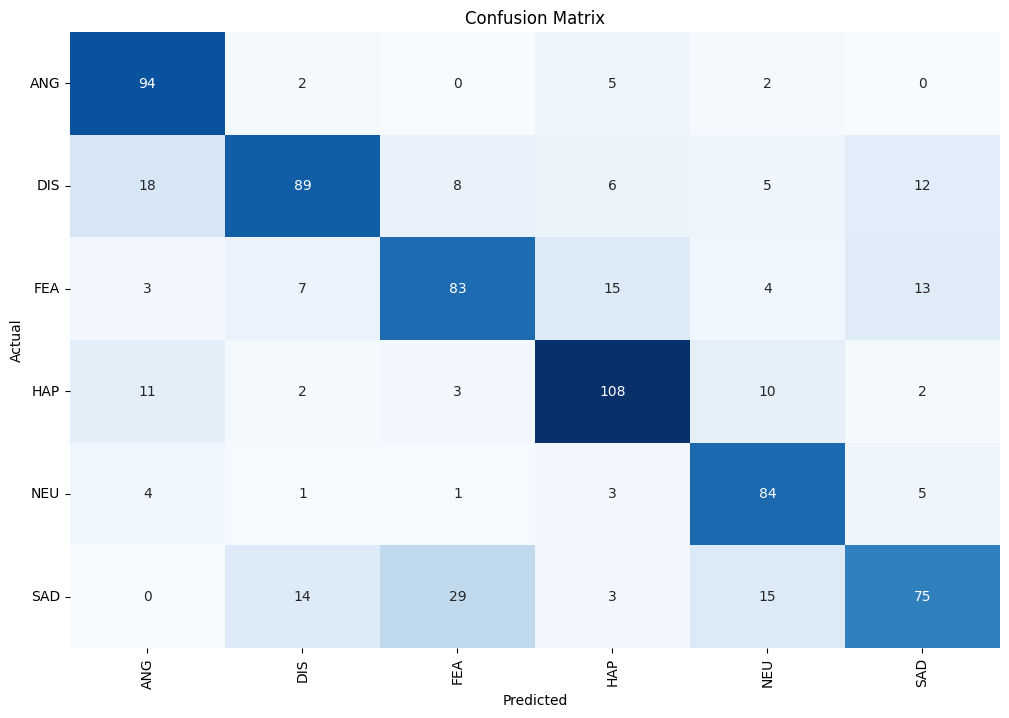

In [64]:
import seaborn as sns
import matplotlib.pyplot as plt

unique_labels = [0, 1, 2, 3, 4, 5]
conf_matrix = confusion_matrix(test["label"], y_pred, labels=unique_labels)
label_mapping = {0: 'ANG', 1: 'DIS', 2: 'FEA', 3: 'HAP', 4: 'NEU', 5: 'SAD'}
custom_labels = [label_mapping[label] for label in unique_labels]
conf_matrix_custom = np.array(conf_matrix, dtype=object)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, vmin=0, fmt='g', cmap='Blues', cbar=False)
plt.xticks(np.arange(6)+.5, custom_labels, rotation=90)
plt.yticks(np.arange(6)+.5, custom_labels, rotation=0)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [67]:
clr = classification_report(test["label"], y_pred, target_names=custom_labels, digits= 6)
print("Classification Report:\n----------------------\n", clr)



Classification Report:
----------------------
               precision    recall  f1-score   support

         ANG   0.723077  0.912621  0.806867       103
         DIS   0.773913  0.644928  0.703557       138
         FEA   0.669355  0.664000  0.666667       125
         HAP   0.771429  0.794118  0.782609       136
         NEU   0.700000  0.857143  0.770642        98
         SAD   0.700935  0.551471  0.617284       136

    accuracy                       0.724185       736
   macro avg   0.723118  0.737380  0.724604       736
weighted avg   0.725255  0.724185  0.719348       736

